In [1]:
import pydicom 
from pathlib import Path
import numpy as np 
import cv2 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from tqdm.notebook import tqdm
import imgaug
from imgaug.augmentables.bbs import BoundingBox
import torch
import torch.nn as nn 
import torchvision 
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
labels=pd.read_csv('rsna_heart_detection.csv')
labels.shape

(496, 8)

In [3]:
np_array=np.load("train_subjects.npy")
np_array

array(['ca112a3c-b701-48b8-a94f-725ea65416a7',
       'e5f292ae-f1e5-497c-b0a0-68f1aa2196b2',
       '67af68f7-7ba0-49a0-a373-3a8801eb0faa',
       '814289a3-9ce8-4cba-842f-45d6a36f540d',
       'e508969f-c931-462b-aa90-ccde34a4d9e5',
       'f1e96436-85c2-4179-b7e9-3f3091e29d76',
       'a20a3112-7585-430c-b648-8d81d301acbf',
       'eb31f994-518b-4e9d-9a52-ccbf541cfa9f',
       '4cf82164-6678-4864-bbc4-5a93419424f7',
       'e20af8e8-56f2-486f-962e-7706d77dc5f5',
       '7f148dfd-80a6-4bef-adc3-d0de8968de74',
       '01ef1712-90a6-4946-ad86-fc76b0cf2d3b',
       '39148a82-bab6-4529-9e66-9b28e8110a8c',
       'd8e5c4af-eb12-45ac-bef7-52067018cc2a',
       'c803f210-4cf1-4914-8399-5950ee8b95d2',
       '799f9a2a-9f6a-4a84-b1e4-e0e6119122bf',
       '79cb22b9-a291-44a2-a1f5-7d51a256e37c',
       '59356ce0-39e8-46c2-942c-bab047e62b4a',
       'e3a261d3-0cfe-4e75-ab0b-1dfd45a9991b',
       '968cdc9c-b3e8-4d54-a2ec-a0932b1ffe35',
       'fe88e494-9645-40b5-bcad-670b8426c9a0',
       '1d5af

In [4]:
root_path=Path('stage_2_train_images/')
save_path=Path('Prcessed-heart-images/')

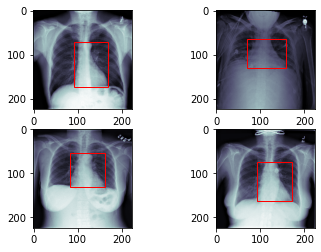

In [5]:
fig,axes=plt.subplots(2,2)
c=0
for i in range(2):
    for j in range(2):
        #To Extract the Image 
        
        data=labels.iloc[c]
        patient_id=data["name"]
        path=(root_path/str(patient_id)).with_suffix('.dcm')
        dcm_array=pydicom.read_file(path).pixel_array
        dcm_array=cv2.resize(dcm_array,(224,224))
        
        #Putting the Bounding Boxes in the image 
        x=data["x0"]
        y=data["y0"]
        width=data["w"]
        hieght=data["h"]
        axes[i][j].imshow(dcm_array,cmap='bone')
        rect=patches.Rectangle((x,y),width,hieght,linewidth=1, edgecolor="r", facecolor='none')
        axes[i][j].add_patch(rect)
        c+=1
        


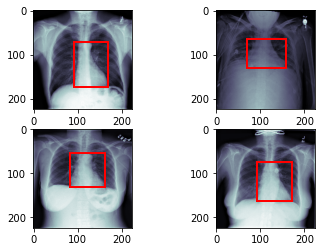

In [6]:
fig, axis = plt.subplots(2, 2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data["name"]
        dcm_path = root_path/str(patient_id)
        dcm_path = dcm_path.with_suffix(".dcm")
        
        dcm = pydicom.read_file(dcm_path)
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))
        
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]
        
        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", facecolor='none')
        axis[i][j].add_patch(rect)
        c+=1

In [7]:
sums=0
sums_squared=0
train_ids=[]
val_ids=[]
for j,patient_ids in enumerate(tqdm(labels.name)):
    path=(root_path/str(patient_ids)).with_suffix('.dcm')
    dcm_array=pydicom.read_file(path).pixel_array
    dcm_array=(cv2.resize(dcm_array,(224,224))/255).astype(np.float16)
    
    #train or Val 
    train_or_val='train' if j<400 else 'val'
    
    if train_or_val=='train':
        train_ids.append(patient_ids)
    else:
        val_ids.append(patient_ids)
        
    direct=save_path/train_or_val
    direct.mkdir(parents=True,exist_ok=True)
    np.save(direct/patient_ids,dcm_array)
    
    #Normalizer
    normalizer=dcm_array.shape[0]*dcm_array.shape[1]
    if train_or_val=='train':
        sums+=np.sum(dcm_array)/normalizer
        sums_squared+=np.sum(np.power(dcm_array,2))/normalizer
    else:
        pass
    
    
    

  0%|          | 0/496 [00:00<?, ?it/s]

In [8]:
len(val_ids)

96

In [9]:
mean=sums/len(train_ids)
std=np.sqrt((sums_squared/len(train_ids))-mean**2)

In [10]:
mean,std

(0.49430165816326493, 0.2527964897943661)

In [5]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self,path_patients_csv,patients,root_path,aug):
        self.labels=pd.read_csv(path_patients_csv)
        self.path=Path(root_path)
        self.patients=np.load(patients)
        self.augment=aug
        
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self,idx):
        patient=self.patients[idx]
        data=self.labels[self.labels["name"]==patient]
        
        x_min=data['x0'].item()
        y_min=data['y0'].item()
        x_max=data['w'].item()+x_min
        y_max=data['h'].item()+y_min
        
        bbox=[x_min,y_min,x_max,y_max]
        img=np.load(f"{self.path/patient}.npy").astype(np.float32)
        
        if self.augment:
            
            bb=BoundingBox(x1=bbox[0],y1=bbox[1],x2=bbox[2],y2=bbox[3])
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            img,aug_bbox=self.augment(image=img,bounding_boxes=bb)
            bbox=aug_bbox[0][0],aug_bbox[0][1],aug_bbox[1][0],aug_bbox[1][1]
            
        img = (img - 0.494) / 0.252
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img,bbox
        
    

In [6]:
import imgaug.augmenters as iaa

In [7]:
seq = iaa.Sequential([
            iaa.GammaContrast(),
            iaa.Affine(
                scale=(0.8, 1.2),
                rotate=(-10, 10),
                translate_px=(-10, 10)
            )
        ])


In [8]:
dataset = CardiacDataset('rsna_heart_detection.csv', "train_subjects.npy", "Prcessed-heart-images/train/", seq)

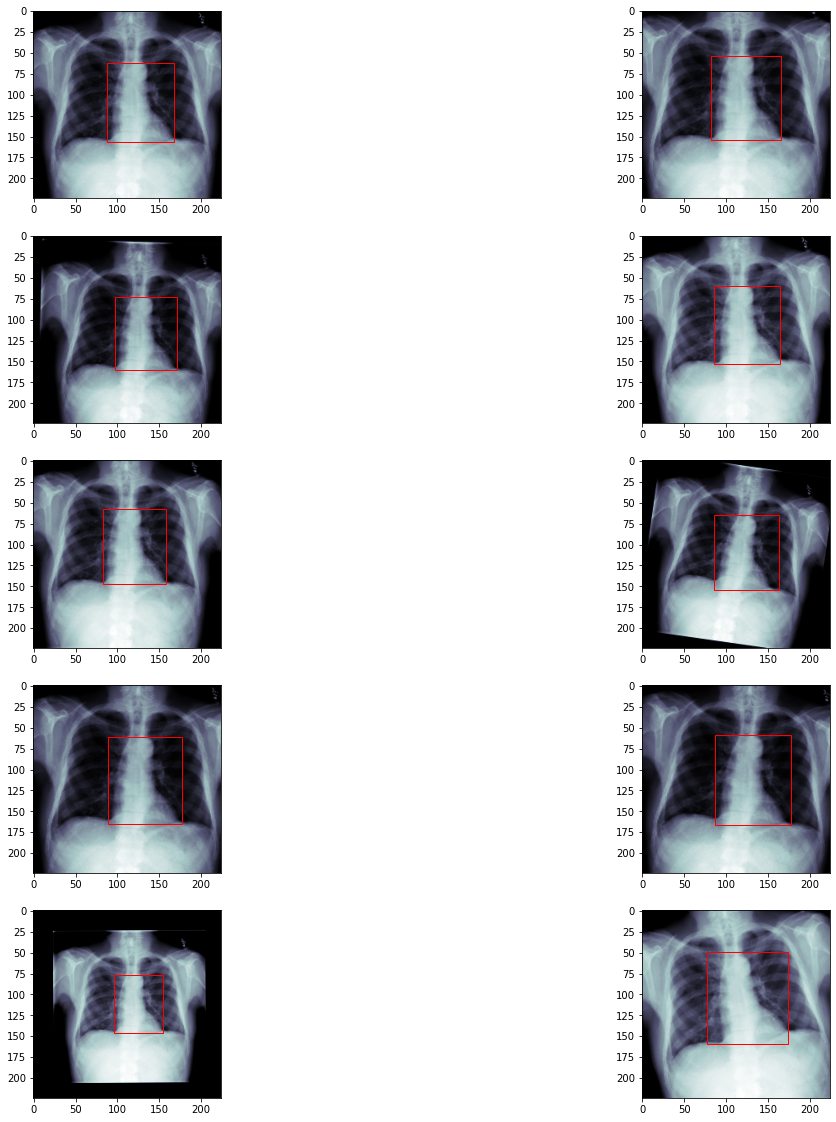

In [53]:
fig, axis = plt.subplots(5, 2,figsize=(20,20))
for i in range(5):
    for j in range(2):
        
    
        img,bbox=dataset[8]
        
        axis[i][j].imshow(img[0], cmap="bone")
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
        axis[i][j].add_patch(rect)

In [17]:
seq=iaa.Sequential([iaa.GammaContrast(),
                  iaa.Affine(scale=(0.8,1.2),
                            rotate=(-10,10),
                            translate_px=(-10,10))])


In [18]:
train_data= CardiacDataset('rsna_heart_detection.csv', "train_subjects.npy", "Prcessed-heart-images/train/", seq)
val_data=CardiacDataset('rsna_heart_detection.csv', "val_subjects.npy", "Prcessed-heart-images/val/",aug=None)

In [19]:
batch_size=16
# num_workers=0
train_dl=DataLoader(train_data,batch_size=batch_size,num_workers=0,shuffle=True,pin_memory=True)
val_dl=DataLoader(val_data,batch_size=16,num_workers=0,shuffle=True,pin_memory=True)

In [20]:
## Loading data on gpu 
#Get the Device Name 
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Load Data to the device
def to_device(data,device):
    
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device,non_blocking=True)
    
    
# Getting a class ready that works with dataLoader class 
class DeviceDataLoader():
    
    def __init__(self,data,device):
        self.data=data
        self.device=device
    
    def __len__(self):
        return len(self.data)
    
    def __iter__(self):
        for x in self.data:
            yield to_device(x,self.device)
            
    
    
device=get_device()
device


device(type='cuda')

In [21]:
train_dl_gpu=DeviceDataLoader(train_dl,device)
val_dl_gpu=DeviceDataLoader(val_dl,device)

In [22]:
len(val_dl_gpu)

6

In [23]:
##Defining the model!!! We are gonna use resnet18 model architecture
class CardiacModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=torchvision.models.resnet18(pretrained=True)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc=nn.Linear(in_features=512, out_features=4, bias=True)
        
    def forward(self,x):
        return self.model(x)

model=CardiacModel()

In [24]:
model.cuda()

CardiacModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [25]:

loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [26]:
#Trainig The model 
validation_losses=[]
train_losses=[]
epochs=200
for epoch in range(epochs):
    for b,(image,bbox) in enumerate(tqdm(train_dl_gpu)):
        b+=1
        result=model(image)
        train_loss=loss_fn(result,bbox)
        
        #updating the parameter 
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        
        for image_val,bbox_val in tqdm(val_dl_gpu):
            result_val=model(image_val)
            val_loss=loss_fn(result_val,bbox_val)
        
    
    print(f"epoch:[{epoch}] train_loss:{train_loss:.4f} val_loss:{val_loss:.4f}")
    
    if val_loss<35:
        print(f'Saving the Model..........................with validation loss {val_loss}')
        torch.save(model.state_dict,'CardiacDetection.pt')
            
    
        

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[0] train_loss:16997.5918 val_loss:15813.9619


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[1] train_loss:14859.5117 val_loss:15418.4883


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[2] train_loss:17001.1641 val_loss:14687.1328


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[3] train_loss:15457.3555 val_loss:15405.0215


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[4] train_loss:15068.0352 val_loss:14539.4609


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[5] train_loss:14520.8662 val_loss:14524.8359


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[6] train_loss:14724.4609 val_loss:13786.2812


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[7] train_loss:15689.1816 val_loss:13453.3174


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[8] train_loss:13817.7461 val_loss:12365.0312


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[9] train_loss:13109.6885 val_loss:12516.7178


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[10] train_loss:13304.8438 val_loss:12274.8008


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[11] train_loss:12588.2051 val_loss:12481.4980


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[12] train_loss:12151.6523 val_loss:11477.0234


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[13] train_loss:11982.7002 val_loss:10951.2930


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[14] train_loss:11440.8330 val_loss:11120.4453


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[15] train_loss:11052.6836 val_loss:10921.4648


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[16] train_loss:12055.3701 val_loss:9843.7891


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[17] train_loss:9647.4414 val_loss:9815.3955


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[18] train_loss:10867.1611 val_loss:8591.2734


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[19] train_loss:9740.4150 val_loss:9197.4541


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[20] train_loss:9882.4824 val_loss:9055.7520


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[21] train_loss:8838.5312 val_loss:7860.8242


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[22] train_loss:8754.6250 val_loss:7866.5654


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[23] train_loss:7994.7041 val_loss:7213.7861


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[24] train_loss:7757.3960 val_loss:7366.1445


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[25] train_loss:7739.1582 val_loss:6982.6777


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[26] train_loss:7195.2607 val_loss:6771.7495


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[27] train_loss:7324.2002 val_loss:7051.6509


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[28] train_loss:6025.9917 val_loss:6410.0977


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[29] train_loss:5895.1318 val_loss:6124.7207


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[30] train_loss:6788.9502 val_loss:5952.2046


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[31] train_loss:6145.7734 val_loss:5969.4795


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[32] train_loss:5719.0107 val_loss:5301.4707


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[33] train_loss:5172.6523 val_loss:5230.6641


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[34] train_loss:5760.0366 val_loss:4340.9531


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[35] train_loss:5431.3770 val_loss:5139.3545


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[36] train_loss:4236.2598 val_loss:4744.9141


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[37] train_loss:3744.9844 val_loss:4246.1440


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[38] train_loss:4808.5439 val_loss:3930.3667


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[39] train_loss:3970.2102 val_loss:3700.5166


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[40] train_loss:4153.5732 val_loss:3594.0613


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[41] train_loss:3461.5437 val_loss:3250.0576


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[42] train_loss:3640.2856 val_loss:3340.8213


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[43] train_loss:3834.6641 val_loss:3279.0674


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[44] train_loss:3523.9160 val_loss:2730.3667


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[45] train_loss:3179.9629 val_loss:2689.3066


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[46] train_loss:2962.8125 val_loss:2570.7769


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[47] train_loss:2851.1699 val_loss:2431.2803


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[48] train_loss:3006.0776 val_loss:2298.4067


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[49] train_loss:2142.3882 val_loss:2285.1895


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[50] train_loss:2316.3494 val_loss:2182.4932


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[51] train_loss:2394.5400 val_loss:1893.8794


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[52] train_loss:2240.1179 val_loss:2073.3979


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[53] train_loss:2185.8638 val_loss:1957.6749


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[54] train_loss:1898.6509 val_loss:1737.2622


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[55] train_loss:1723.7844 val_loss:1553.7443


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[56] train_loss:1590.3013 val_loss:1465.4554


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[57] train_loss:1640.4116 val_loss:1543.6676


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[58] train_loss:1836.4375 val_loss:1247.5842


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[59] train_loss:1691.1251 val_loss:1352.2209


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[60] train_loss:1298.3644 val_loss:1293.6359


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[61] train_loss:1469.3174 val_loss:931.4894


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[62] train_loss:1370.4060 val_loss:931.3558


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[63] train_loss:1295.0814 val_loss:889.8060


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[64] train_loss:1199.9968 val_loss:982.9856


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[65] train_loss:929.4337 val_loss:680.1666


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[66] train_loss:1065.9343 val_loss:704.7330


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[67] train_loss:909.3115 val_loss:626.5668


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[68] train_loss:1077.8174 val_loss:530.8713


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[69] train_loss:957.2968 val_loss:616.1123


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[70] train_loss:435.0140 val_loss:533.0018


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[71] train_loss:554.3554 val_loss:461.6730


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[72] train_loss:524.3256 val_loss:525.5469


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[73] train_loss:607.8258 val_loss:538.8658


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[74] train_loss:522.7335 val_loss:434.1906


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[75] train_loss:487.1246 val_loss:661.3412


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[76] train_loss:492.3550 val_loss:335.4821


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[77] train_loss:486.8953 val_loss:287.6496


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[78] train_loss:464.6837 val_loss:180.9441


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[79] train_loss:418.4957 val_loss:188.5011


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[80] train_loss:587.3751 val_loss:276.7448


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[81] train_loss:366.6564 val_loss:208.6807


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[82] train_loss:458.5345 val_loss:258.4684


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[83] train_loss:207.9401 val_loss:184.5752


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[84] train_loss:371.3860 val_loss:236.8722


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[85] train_loss:395.4177 val_loss:157.8146


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[86] train_loss:281.9723 val_loss:171.1675


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[87] train_loss:203.9133 val_loss:149.3345


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[88] train_loss:301.0605 val_loss:199.7071


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[89] train_loss:226.5381 val_loss:159.4813


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[90] train_loss:248.5890 val_loss:79.3040


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[91] train_loss:136.1166 val_loss:117.3381


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[92] train_loss:258.8403 val_loss:130.9822


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[93] train_loss:157.8949 val_loss:81.8257


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[94] train_loss:142.9057 val_loss:119.5117


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[95] train_loss:261.2415 val_loss:197.2702


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[96] train_loss:290.4540 val_loss:94.4109


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[97] train_loss:88.4329 val_loss:101.9516


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[98] train_loss:214.9203 val_loss:92.3779


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[99] train_loss:118.5210 val_loss:106.0467


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[100] train_loss:104.4649 val_loss:128.1183


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[101] train_loss:99.0675 val_loss:120.2602


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[102] train_loss:141.2070 val_loss:118.7627


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[103] train_loss:103.8959 val_loss:59.6160


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[104] train_loss:291.3656 val_loss:75.1385


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[105] train_loss:174.8892 val_loss:70.8656


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[106] train_loss:119.7884 val_loss:56.3459


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[107] train_loss:98.2298 val_loss:99.5491


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[108] train_loss:54.2805 val_loss:78.4813


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[109] train_loss:103.5634 val_loss:75.9173


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[110] train_loss:121.4144 val_loss:111.1007


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[111] train_loss:94.9577 val_loss:111.2220


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[112] train_loss:66.2682 val_loss:95.8229


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[113] train_loss:73.6543 val_loss:87.2268


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[114] train_loss:138.2070 val_loss:70.2169


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[115] train_loss:24.0952 val_loss:78.9614


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[116] train_loss:53.2451 val_loss:133.3180


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[117] train_loss:72.3151 val_loss:63.4174


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[118] train_loss:62.2738 val_loss:66.3204


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[119] train_loss:82.4605 val_loss:72.0879


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[120] train_loss:95.0033 val_loss:68.4811


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[121] train_loss:84.8323 val_loss:78.3869


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[122] train_loss:50.6469 val_loss:63.4274


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[123] train_loss:51.1576 val_loss:77.2546


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[124] train_loss:27.2379 val_loss:78.7706


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[125] train_loss:49.3191 val_loss:89.1001


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[126] train_loss:43.0997 val_loss:42.1400


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[127] train_loss:34.5971 val_loss:58.1030


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[128] train_loss:93.5872 val_loss:105.1331


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[129] train_loss:86.9598 val_loss:70.4844


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[130] train_loss:113.7393 val_loss:31.5725
Saving the Model..........................with validation loss 31.572500228881836


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[131] train_loss:33.1019 val_loss:71.6012


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[132] train_loss:45.5566 val_loss:28.5799
Saving the Model..........................with validation loss 28.57992172241211


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[133] train_loss:37.3513 val_loss:50.9128


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[134] train_loss:39.6426 val_loss:75.4821


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[135] train_loss:51.8736 val_loss:117.7189


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[136] train_loss:31.9739 val_loss:52.0460


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[137] train_loss:24.8937 val_loss:37.6607


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[138] train_loss:35.0507 val_loss:62.2518


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[139] train_loss:45.5136 val_loss:42.5835


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[140] train_loss:80.9639 val_loss:38.7697


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[141] train_loss:53.5158 val_loss:66.5780


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[142] train_loss:31.1118 val_loss:71.8813


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[143] train_loss:29.2095 val_loss:44.0395


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[144] train_loss:23.2515 val_loss:38.1131


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[145] train_loss:35.9187 val_loss:56.7615


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[146] train_loss:29.3764 val_loss:60.3970


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[147] train_loss:19.4076 val_loss:68.9403


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[148] train_loss:47.4929 val_loss:74.6778


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[149] train_loss:26.1364 val_loss:39.6787


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[150] train_loss:16.5352 val_loss:52.2659


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[151] train_loss:61.0692 val_loss:64.1388


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[152] train_loss:24.8155 val_loss:57.5503


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[153] train_loss:35.9046 val_loss:53.1496


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[154] train_loss:39.0676 val_loss:58.0193


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[155] train_loss:23.3902 val_loss:48.7843


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[156] train_loss:34.0430 val_loss:93.6993


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[157] train_loss:22.9831 val_loss:43.7156


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[158] train_loss:38.7574 val_loss:45.9791


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[159] train_loss:33.6651 val_loss:44.7421


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[160] train_loss:61.3084 val_loss:44.5130


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[161] train_loss:38.4594 val_loss:61.7578


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[162] train_loss:28.7136 val_loss:58.3238


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[163] train_loss:26.9724 val_loss:54.0454


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[164] train_loss:37.1097 val_loss:53.5924


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[165] train_loss:19.0765 val_loss:40.4221


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[166] train_loss:20.6610 val_loss:71.2943


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[167] train_loss:21.2044 val_loss:64.5733


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[168] train_loss:16.1074 val_loss:67.1548


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[169] train_loss:14.5132 val_loss:85.4158


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[170] train_loss:34.9546 val_loss:49.9147


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[171] train_loss:21.8694 val_loss:59.0361


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[172] train_loss:25.7539 val_loss:98.8353


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[173] train_loss:26.5810 val_loss:53.5875


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[174] train_loss:19.2096 val_loss:59.6003


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[175] train_loss:32.5712 val_loss:76.5250


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[176] train_loss:43.3363 val_loss:81.2559


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[177] train_loss:59.4963 val_loss:96.5498


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[178] train_loss:15.4263 val_loss:47.2711


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[179] train_loss:37.8804 val_loss:48.5949


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[180] train_loss:42.0723 val_loss:59.2773


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[181] train_loss:57.7440 val_loss:63.2277


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[182] train_loss:11.8290 val_loss:57.6995


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[183] train_loss:20.8211 val_loss:45.6309


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[184] train_loss:17.1700 val_loss:42.7412


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[185] train_loss:18.1389 val_loss:45.8916


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[186] train_loss:16.8757 val_loss:40.8089


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[187] train_loss:18.2155 val_loss:47.3849


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[188] train_loss:22.9329 val_loss:56.9631


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[189] train_loss:12.2559 val_loss:95.5975


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[190] train_loss:20.9971 val_loss:82.0356


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[191] train_loss:21.1025 val_loss:44.3651


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[192] train_loss:20.7455 val_loss:42.9971


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[193] train_loss:31.4696 val_loss:77.0793


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[194] train_loss:15.9392 val_loss:38.2114


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[195] train_loss:21.7852 val_loss:58.6414


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[196] train_loss:20.7830 val_loss:39.2241


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[197] train_loss:14.1969 val_loss:63.6136


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[198] train_loss:10.3049 val_loss:40.0720


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

epoch:[199] train_loss:23.4963 val_loss:64.6568


In [29]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_data:
        data = data.float().unsqueeze(0).cuda()
        pred = model(data)[0]
        preds.append(pred.cpu())
        labels.append(label.cpu())
        
preds=torch.stack(preds)
labels=torch.stack(labels)


tensor([ 91,  62, 180, 161])


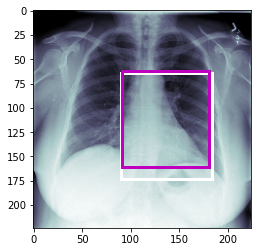

In [46]:
IDX=17
img, label = val_data[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart1 = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=3, edgecolor='w', facecolor='none')
axis.add_patch(heart1)
# axis[1].imshow(img[0],cmap='bone')
heart2=patches.Rectangle((label[0], label[1]), label[2]-label[0],
                          label[3]-label[1], linewidth=3, edgecolor='m', facecolor='none')
axis.add_patch(heart2)
print(label)

In [39]:
abs(preds-labels).mean(0)

tensor([ 7.7116,  8.0682, 15.8162, 15.7779])